Ładujemy potrzebne biblioteki


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import MeanShift
import numpy as np

In [2]:
#ładowanie ścieżek dostępu
full_path = r'CSV/showcase_fxts.csv'
#os.chdir(full_path)
#files = os.listdir()
#fname = files[10]

C:\Users\PC\AppData\Local\Temp/ipykernel_18944/2730781089.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_D_casa['mean_x_k'] = 0
C:\Users\PC\AppData\Local\Temp/ipykernel_18944/2730781089.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_D_casa['mean_y_k'] = 0
D:\Users\PC\anaconda3\envs\spyder-4.2.5\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

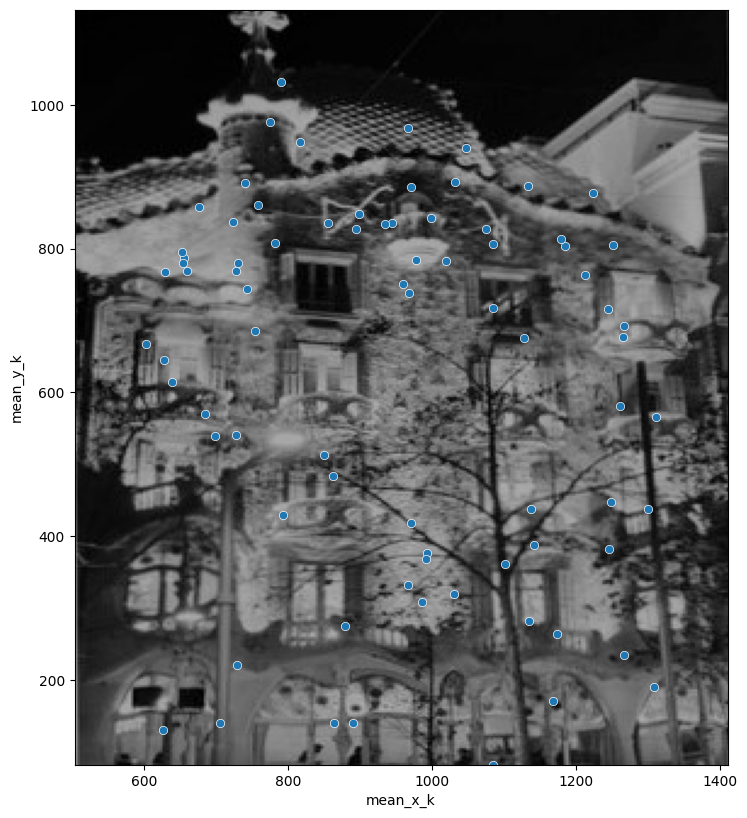

In [3]:
#selekcja interesujących nas rekordów - w tym przypadku zdjecie 'casa' i osoba 'D'
df = pd.read_csv(full_path)
#df.set_index('Order')
#df_D_casa = df[df['trial_id'] == 'casa']
df_D_casa = df[(df['subj'] == 'P') & (df['trial_id'] == 'casa')]
df_D_casa.set_index('Order')


#tworzymy dodatkowe dwie puste kolumny dla współrzędnych końca sakady (czyli punktu fiksacyjnego kolejnego w kolejności patrzenia)
df_D_casa['mean_x_k'] = 0
df_D_casa['mean_y_k'] = 0

#tworzymy wirtualne sakkady, czyli współrzędne punktu fiksacji n oraz współrzędne pinktu fiksacji n+1
for n in range(0, len(df_D_casa)-1):
    df_D_casa['mean_x_k'].iloc[n] = df_D_casa['mean_x'].iloc[n+1]
    df_D_casa['mean_y_k'].iloc[n] = df_D_casa['mean_y'].iloc[n+1]
df_D_casa = df_D_casa[:-1] #tutaj ucieka nam brakujący rekord z końca, bo dla niego nie ma już n+1 - zastanowić się co z nim zrobić?

#prosta wizualizacja scatterplot, by zobaczyć czy działa

img_path = r'C:\Users\PC\Desktop\SEMESTER 5\Krejz\to_R\casa3.jpeg'
img = plt.imread(img_path)

fig, ax = plt.subplots(1, figsize=(15, 10), dpi=100)
sns.scatterplot(df_D_casa.mean_x_k, df_D_casa.mean_y_k)
ax.imshow(img, extent=[df_D_casa['mean_x'].min() - 100, df_D_casa['mean_x'].max() + 100, 
                                  df_D_casa['mean_y'].min(), df_D_casa['mean_y'].max() + 100])
plt.show()


In [4]:
print(df_D_casa['mean_x'].min())
print(df_D_casa['mean_x'].max())
print(df_D_casa['mean_y'].min())
print(df_D_casa['mean_y'].max())

603.29280155263
1311.14188720703
82.6041359901428
1032.1931029289


Klasteryzacja w wymiarze współrzędnych za pomocą algorytmu MeanShift (takiego samego używał autor pracy, którą się posiłkowałem). Parametr 'bandwidth' odpowiada za odległość, w której szukamy najbliższych sąsiadów. Jest do ustawienia empirycznego, lecz wartość 100 wydaje się zadowalająca przy małym zbiorze danych (>100). Przy większych zbiorach, należy dobierać ręcznie.

D:\Users\PC\anaconda3\envs\spyder-4.2.5\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


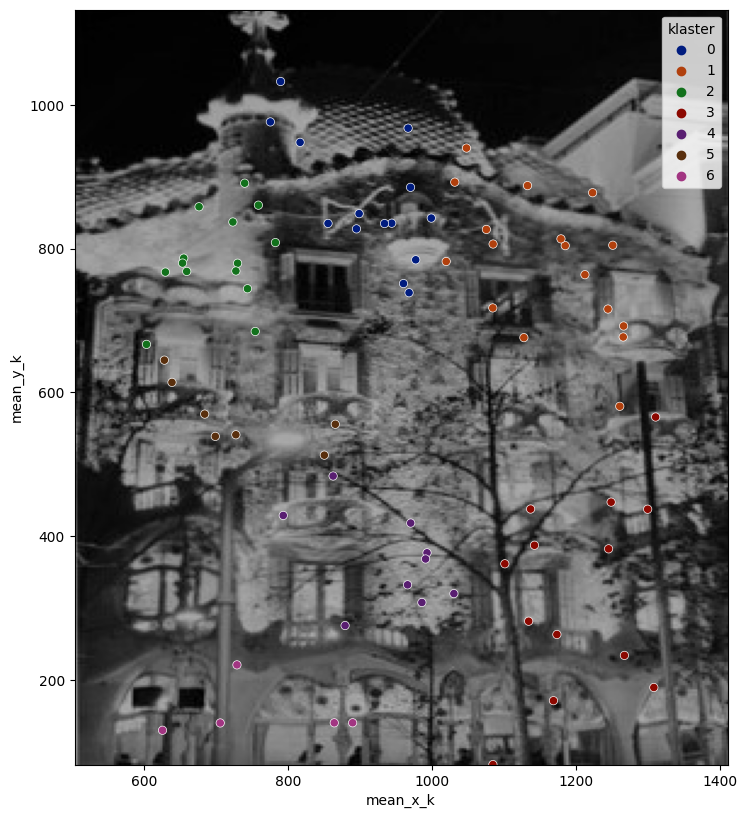

In [5]:
#tworzymy nowy DataFrame w celu przechowywania tylko istotnych danych dla analiz, na podstawie poprzedniego przefiltrowanego DataFrame'a
column_names = []
df_pozitions = pd.DataFrame(columns = column_names)

df_pozitions['mean_x_k'] = df_D_casa['mean_x'] 
df_pozitions['mean_y_k'] = df_D_casa['mean_y'] 
#df_pozitions['Order'] = df_D_casa['Order']
df_pozitions

#df_pozitions.set_index('Order')

clustering = MeanShift(bandwidth=175).fit(df_pozitions)
df_pozitions['klaster'] = clustering.labels_ #dodajemy kolumne z ID klastra
#następnie dodajemy do DF'a na którym pracujemy wartości potrzebne do optymalizacji przerw naturalnych - do klasteryzacji w wymiarze czasu
df_pozitions['Duration'] = df_D_casa['Duration'] 
df_pozitions['Start'] = df_D_casa['Start'] 
df_pozitions['End'] = df_D_casa['End'] 


fig, ax = plt.subplots(1, figsize=(15, 10), dpi=100)

#wizyalizacja po klateryzacji w wymiarze przestrzeni
sns.scatterplot(df_pozitions.mean_x_k, df_pozitions.mean_y_k, hue = df_pozitions.klaster, palette = 'dark', legend = True)
#jeśli nie zadziała, to przeładować komórkę wyżej jeszcze raz, bo z jakiegoś nieznanego mi powodu nie odświeża danych

img_path = r'C:\Users\PC\Desktop\SEMESTER 5\Krejz\to_R\casa3.jpeg'
img = plt.imread(img_path)



ax.imshow(img, extent=[df_D_casa['mean_x'].min() - 100, df_D_casa['mean_x'].max() + 100, 
                                  df_D_casa['mean_y'].min(), df_D_casa['mean_y'].max() + 100])
plt.show()


Naiwna kolejność po średniej z Duration lub Start_time(<- to raczej rozsądniejsze)

In [6]:
#df_duration_time = df_pozitions.groupby('klaster')['Duration'].agg(['sum', 'mean', 'std']).round(1)
#display(df_duration_time.sort_values(by = 'mean'))

df_start_time = df_pozitions.groupby('klaster')['Start'].agg(['sum', 'mean', 'std']).round(1)
display(df_start_time.sort_values(by = 'mean'))


,sum,mean,std
klaster,,,
0,162780.7,11627.2,8046.5
6,58478.3,11695.7,10243.0
5,86193.7,12313.4,11690.6
3,175999.7,13538.4,9802.6
1,252117.0,14830.4,6070.1
4,134789.0,14976.6,11196.0
2,288394.0,20599.6,6804.5


Wizualizacja fency, nie wiem czy potrzebna

In [7]:
slownik = dict()
for index, row in df_pozitions.iterrows():
    k = row['klaster']
    if k not in slownik:
        slownik[k] = list()
    slownik[k].append((row['mean_x_k'], row['mean_y_k'])) 
    
slownik

center = pd.DataFrame(columns = ['klaster', 'x', 'y'])
for i, v in slownik.items():
    x = 0
    y = 0
    for xy in v:
        x += xy[0]
        y += xy[1]
    xc = x/len(v)
    yc = y/len(v)
    center.loc[i] = np.array([i, xc, yc])

In [8]:
#tylko do rysowania jest ptrzebne sortowanie tutaj
display(center.sort_index())
display(df_start_time.sort_index())

,klaster,x,y
0.0,0.0,910.972855,864.687791
1.0,1.0,1158.721729,779.830702
2.0,2.0,702.674018,785.732368
3.0,3.0,1202.026922,326.463805
4.0,4.0,941.540187,368.131727
5.0,5.0,727.720977,568.151809
6.0,6.0,762.950046,154.684064


,sum,mean,std
klaster,,,
0,162780.7,11627.2,8046.5
1,252117.0,14830.4,6070.1
2,288394.0,20599.6,6804.5
3,175999.7,13538.4,9802.6
4,134789.0,14976.6,11196.0
5,86193.7,12313.4,11690.6
6,58478.3,11695.7,10243.0


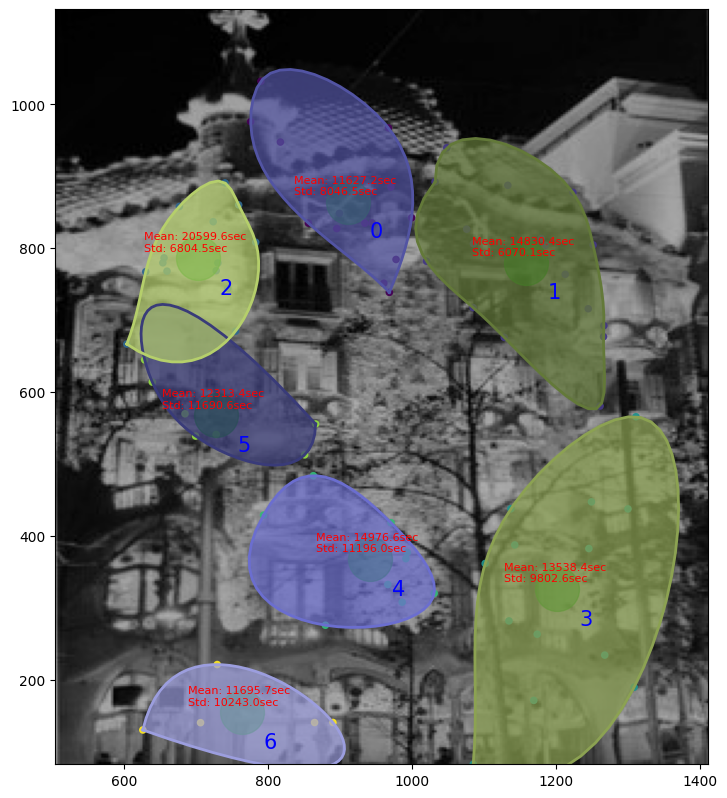

In [9]:
from scipy import interpolate
from scipy.spatial import ConvexHull
from matplotlib.cm import get_cmap

fig, ax = plt.subplots(1, figsize=(15, 10), dpi=100)
plt.scatter(df_pozitions.mean_x_k, df_pozitions.mean_y_k, c=df_pozitions.klaster, alpha = 0.9, s=20)
#sns.scatterplot(df_pozitions.mean_x_k, df_pozitions.mean_y_k, hue = df_pozitions.klaster, palette = 'dark', legend = False)
plt.scatter(center.x, center.y, c='g', s=1000, alpha = 0.6)

for d in range(len(df_start_time)):
    text = 'Mean: ' + str(df_start_time['mean'][d]) +'sec' '\n' 'Std: ' + str(df_start_time['std'][d])  +'sec' 
    plt.text(x = center.x[d]-75, y = center.y[d]+10, s = text, fontdict = dict(color = 'red', size = 8))
    plt.text(x = center.x[d]+30, y = center.y[d]-50, s = df_start_time.index[d], fontdict = dict(color = 'blue', size = 15))

name = "tab20b"
cmap = get_cmap(name)  # type: matplotlib.colors.ListedColormap
colors = cmap.colors  # type: list
ax.set_prop_cycle(color=colors)

for i in df_pozitions.klaster.unique():
    # get the convex hull
    points = df_pozitions[df_pozitions.klaster == i][['mean_x_k', 'mean_y_k']].values
    hull = ConvexHull(points)
    x_hull = np.append(points[hull.vertices,0],
                       points[hull.vertices,0][0])
    y_hull = np.append(points[hull.vertices,1],
                       points[hull.vertices,1][0])
    
    # interpolate
    dist = np.sqrt((x_hull[:-1] - x_hull[1:])**2 + (y_hull[:-1] - y_hull[1:])**2)
    dist_along = np.concatenate(([0], dist.cumsum()))
    spline, u = interpolate.splprep([x_hull, y_hull], 
                                    u=dist_along, s=0)
    interp_d = np.linspace(dist_along[0], dist_along[-1], 50)
    interp_x, interp_y = interpolate.splev(interp_d, spline)
    # plot shape
    plt.fill(interp_x, interp_y, '--', alpha=0.7)
    plt.plot(interp_x, interp_y, alpha=1, linewidth = 2)

img_path = r'C:\Users\PC\Desktop\SEMESTER 5\Krejz\to_R\casa3.jpeg'
img = plt.imread(img_path)

ax.imshow(img, extent=[df_D_casa['mean_x'].min() - 100, df_D_casa['mean_x'].max() + 100, 
                                  df_D_casa['mean_y'].min(), df_D_casa['mean_y'].max() + 100])
plt.show()


In [10]:
#To jest podstawa do analiz Levensteina
df_start_time_sorted = df_start_time.sort_values(by = 'mean')
display(df_start_time_sorted)
#do listy
naive_leven_list = df_start_time_sorted.index.tolist()
naive_leven_list

,sum,mean,std
klaster,,,
0,162780.7,11627.2,8046.5
6,58478.3,11695.7,10243.0
5,86193.7,12313.4,11690.6
3,175999.7,13538.4,9802.6
1,252117.0,14830.4,6070.1
4,134789.0,14976.6,11196.0
2,288394.0,20599.6,6804.5


[0, 6, 5, 3, 1, 4, 2]

In [11]:
#sprawdzamy podstawowe parametry opisowe dla poszczególnych klastrów w domeneie czasu
def std(x): return np.std(x)
df_pogrupwoae_srednia = df_pozitions.groupby(['klaster'])['Start'].agg(['mean', std]).sort_values(by = 'mean').round(0)
df_pogrupwoae_srednia

,mean,std
klaster,,
0,11627.0,7754.0
6,11696.0,9162.0
5,12313.0,10823.0
3,13538.0,9418.0
1,14830.0,5889.0
4,14977.0,10556.0
2,20600.0,6557.0


Optymalizacja przerw naturalnych - czyli klasteryzacja jednowymiarowa, w domenie czasu

In [12]:
list_to_merge = list()

for i in range(0, len(df_pogrupwoae_srednia)):

    test = df_pozitions[df_pozitions['klaster'] == i]
    points = list(test['Start'])

    clusters = []
    #eps =  0.5 * df_pogrupwoae_srednia['std'][i]
    eps =  3000 #wybrane empisrycznmie, wcześniej std, ale rozdzielało zmienne które czasowo są bardzo blisko siebie, do dyskusji
    points_sorted = sorted(points)
    curr_point = points_sorted[0]
    curr_cluster = [curr_point]
    for point in points_sorted[1:]:
        if point <= curr_point + eps:
            curr_cluster.append(point)
        else:
            clusters.append(curr_cluster)
            curr_cluster = [point]
        curr_point = point
    clusters.append(curr_cluster)
    nazwy = list(range(1, len(clusters) + 1))
    dic = dict(zip(nazwy, clusters))
    
    for key, values in dic.items():    
        for value in values:
            list_to_merge.append(key)
            list_to_merge.append(value)
            
print(list_to_merge)

#łączymy klastry w domeneie czasu z naszym DF'em na którym pracyjemy cały czas
output_array = np.array(list_to_merge).reshape(-1,2)
df_with_time_claster = df_pozitions.merge(pd.DataFrame(output_array, columns = ['time_klaster', 'Start']))

#powstaje nam DF, który ma w sobie klastry w domenie pozycyjnej i klastry w domenie czasowej
df_with_time_claster

[1, 314.333333333333, 1, 1921.0, 1, 2194.33333333333, 1, 2434.33333333333, 2, 9994.33333333333, 2, 10234.3333333333, 2, 11514.3333333333, 2, 11774.3333333333, 2, 12514.3333333333, 2, 14254.3333333333, 3, 18154.3333333333, 3, 18661.0, 4, 21674.3333333333, 5, 27141.0, 1, 3201.0, 2, 8154.33333333333, 2, 8994.33333333333, 2, 9274.33333333333, 2, 9474.33333333333, 2, 9681.0, 2, 10694.3333333333, 3, 14041.0, 3, 16374.3333333333, 3, 18361.0, 3, 18894.3333333333, 3, 19194.3333333333, 3, 19361.0, 3, 19614.3333333333, 3, 20667.6666666667, 3, 21034.3333333333, 4, 25101.0, 1, 12174.3333333333, 1, 13354.3333333333, 1, 14621.0, 1, 14854.3333333333, 1, 15194.3333333333, 1, 15481.0, 1, 16707.6666666667, 1, 17894.3333333333, 2, 27301.0, 2, 27547.6666666667, 2, 27854.3333333333, 2, 28214.3333333333, 2, 28421.0, 2, 28774.3333333333, 1, 3534.33333333333, 1, 3834.33333333333, 1, 5174.33333333333, 1, 6807.66666666667, 1, 7034.33333333333, 1, 7481.0, 1, 7654.33333333333, 1, 7914.33333333333, 2, 23694.3333333

,mean_x_k,mean_y_k,klaster,Duration,Start,End,time_klaster
0,865.831894,555.703800,5,300.000000,1.000000,300.000000,1.0
1,960.601021,751.324057,0,626.666667,314.333333,940.000000,1.0
2,879.390514,275.904128,4,186.666667,954.333333,1140.000000,1.0
3,889.875059,140.734148,6,606.666667,1154.333333,1760.000000,1.0
4,993.307482,377.003225,4,113.333333,1781.000000,1893.333333,1.0
...,...,...,...,...,...,...,...
74,727.603381,768.789237,2,353.333333,27854.333333,28206.666667,2.0
75,629.608055,767.253600,2,193.333333,28214.333333,28406.666667,2.0
76,743.728430,744.136928,2,346.666667,28421.000000,28766.666667,2.0
77,758.879398,860.289694,2,213.333333,28774.333333,28986.666667,2.0


D:\Users\PC\anaconda3\envs\spyder-4.2.5\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


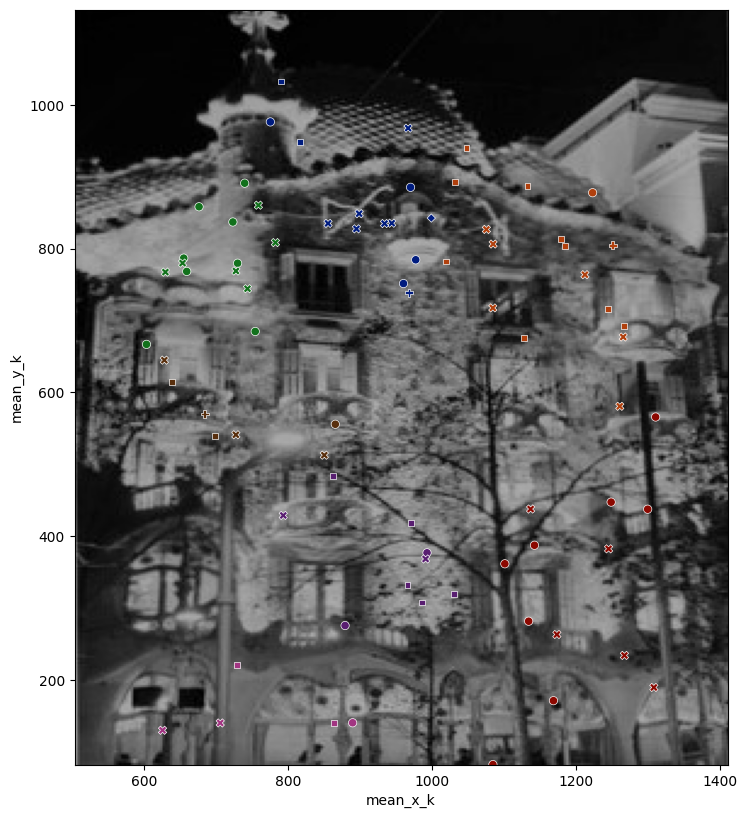

In [13]:
fig, ax = plt.subplots(1, figsize=(15, 10), dpi=100)
#wizualizujemy klastry w domenie czasoso-pozycyjnej - kolor oznacza klaster pozycyjny, w którym rozróżniamy za pomocą kształtów również podklastry w domenie czasu
sns.scatterplot(df_with_time_claster.mean_x_k, df_with_time_claster.mean_y_k, hue = df_with_time_claster.klaster, palette = 'dark', style = df_with_time_claster.time_klaster, legend = False)

img_path = r'C:\Users\PC\Desktop\SEMESTER 5\Krejz\to_R\casa3.jpeg'
img = plt.imread(img_path)

ax.imshow(img, extent=[df_D_casa['mean_x'].min() - 100, df_D_casa['mean_x'].max() + 100, 
                                  df_D_casa['mean_y'].min(), df_D_casa['mean_y'].max() + 100])
plt.show()

In [14]:
#prosta operacja na nazwach klastrów, żeby ujednolicić nazewnictwo i mieć w jednej nazwie zawartą informację o tym do jakiego klastra pozycyjnego i czasowego należy rekord
df_with_time_claster['finish_claster'] = df_with_time_claster.apply(lambda row: int(row.klaster) * 100 + int(row.time_klaster), axis =1)
df_kolejnosc = df_with_time_claster.groupby(['finish_claster'])['Start'].min().sort_values() #ustalenie kolejności przebiegu patrzenia
df_with_time_claster

,mean_x_k,mean_y_k,klaster,Duration,Start,End,time_klaster,finish_claster
0,865.831894,555.703800,5,300.000000,1.000000,300.000000,1.0,501
1,960.601021,751.324057,0,626.666667,314.333333,940.000000,1.0,1
2,879.390514,275.904128,4,186.666667,954.333333,1140.000000,1.0,401
3,889.875059,140.734148,6,606.666667,1154.333333,1760.000000,1.0,601
4,993.307482,377.003225,4,113.333333,1781.000000,1893.333333,1.0,401
...,...,...,...,...,...,...,...,...
74,727.603381,768.789237,2,353.333333,27854.333333,28206.666667,2.0,202
75,629.608055,767.253600,2,193.333333,28214.333333,28406.666667,2.0,202
76,743.728430,744.136928,2,346.666667,28421.000000,28766.666667,2.0,202
77,758.879398,860.289694,2,213.333333,28774.333333,28986.666667,2.0,202


In [15]:
#df_duration_time_finish_claster = df_with_time_claster.groupby('finish_claster')['Duration'].agg(['sum', 'mean', 'std']).round(1)
#display(df_duration_time_finish_claster.sort_values(by = 'mean'))

df_start_time_finish_claster = df_with_time_claster.groupby('finish_claster')['Start'].agg(['sum', 'mean', 'std']).round(1)
display(df_start_time_finish_claster.sort_values(by = 'mean'))


,sum,mean,std
finish_claster,,,
501,1.0,1.0,NaN
601,1154.3,1154.3,NaN
401,2735.3,1367.7,584.5
1,6864.0,1716.0,957.7
101,3201.0,3201.0,NaN
502,12836.3,4278.8,261.4
402,10402.0,5201.0,471.4
602,11908.7,5954.3,198.0
301,49434.7,6179.3,1753.0


In [16]:
#To jest podstawa do analiz Levensteina
df_start_time_finish_claster_sorted = df_start_time_finish_claster.sort_values(by = 'mean')
display(df_start_time_finish_claster_sorted)
#do listy
leven_list = df_start_time_finish_claster_sorted.index.tolist()
leven_list

,sum,mean,std
finish_claster,,,
501,1.0,1.0,NaN
601,1154.3,1154.3,NaN
401,2735.3,1367.7,584.5
1,6864.0,1716.0,957.7
101,3201.0,3201.0,NaN
502,12836.3,4278.8,261.4
402,10402.0,5201.0,471.4
602,11908.7,5954.3,198.0
301,49434.7,6179.3,1753.0


[501,
 601,
 401,
 1,
 101,
 502,
 402,
 602,
 301,
 102,
 2,
 201,
 3,
 103,
 4,
 503,
 603,
 403,
 104,
 302,
 5,
 202,
 504]

In [17]:
df_kolejnosc.reset_index()

,finish_claster,Start
0,501,1.000000
1,1,314.333333
2,401,954.333333
3,601,1154.333333
4,101,3201.000000
5,301,3534.333333
6,502,4034.333333
7,402,4867.666667
8,602,5814.333333
9,102,8154.333333


Liczymy środki ciężkości klastrów - czyli centra klastrów, od których potem będą szły łączenia

D:\Users\PC\anaconda3\envs\spyder-4.2.5\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


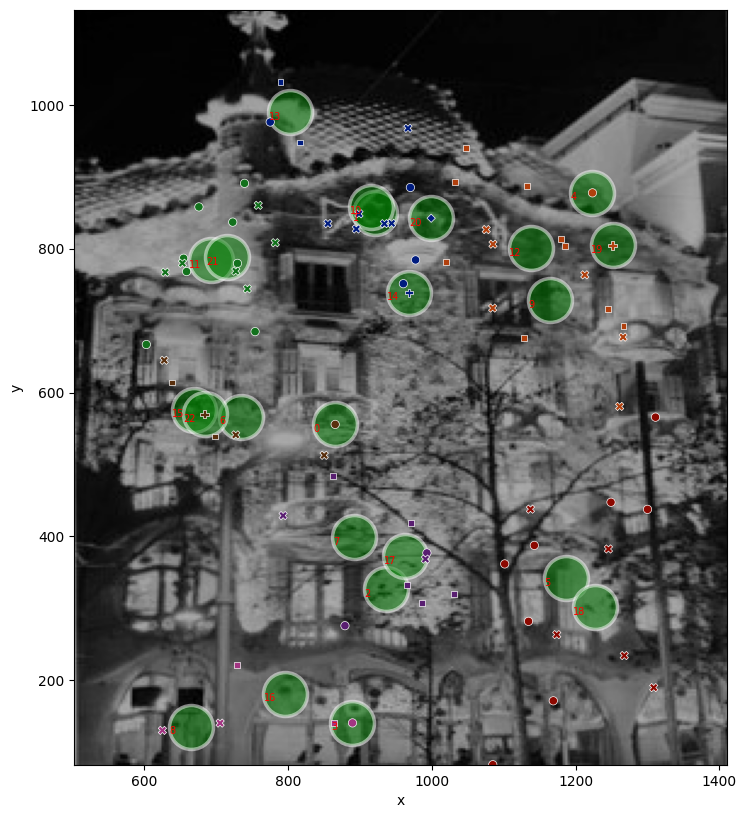

In [18]:
slownik = dict()
for index, row in df_with_time_claster.iterrows():
    k = row['finish_claster']
    if k not in slownik:
        slownik[k] = list()
    slownik[k].append((row['mean_x_k'], row['mean_y_k'])) 
    
df = pd.DataFrame(columns = ['finish_claster', 'x', 'y'])
for i, v in slownik.items():
    x = 0
    y = 0
    for xy in v:
        x += xy[0]
        y += xy[1]
    xc = x/len(v)
    yc = y/len(v)
    df.loc[i] = np.array([i, xc, yc])

df['x'] = pd.to_numeric(df['x'])
df['y'] = pd.to_numeric(df['y'])
df_to_R = df_kolejnosc.to_frame().merge(df, on = 'finish_claster')

#wizualizacja 
fig, ax = plt.subplots(1, figsize=(15, 10), dpi=100)

sns.scatterplot(x = df.x, y = df.y, s = 1000, alpha = 0.5, color = 'g')
sns.scatterplot(df_with_time_claster.mean_x_k, df_with_time_claster.mean_y_k, hue = df_with_time_claster.klaster, palette = 'dark', style = df_with_time_claster.time_klaster, legend = False)
for line in range(0, df_to_R.shape[0]):
    plt.text(x = df_to_R.x[line]-30, y = df_to_R.y[line]-10, s = df_to_R.index[line], fontdict = dict(color = 'red', size = 7))
    
img_path = r'C:\Users\PC\Desktop\SEMESTER 5\Krejz\to_R\casa3.jpeg'
img = plt.imread(img_path)

ax.imshow(img, extent=[df_D_casa['mean_x'].min() - 100, df_D_casa['mean_x'].max() + 100, 
                                  df_D_casa['mean_y'].min(), df_D_casa['mean_y'].max() + 100])
plt.show()

In [19]:
df_to_R


,finish_claster,Start,x,y
0,501,1.000000,865.831894,555.703800
1,1,314.333333,921.030345,849.204461
2,401,954.333333,936.348998,326.453677
3,601,1154.333333,889.875059,140.734148
4,101,3201.000000,1223.479341,877.606730
5,301,3534.333333,1186.646065,342.000215
6,502,4034.333333,735.421292,566.237317
7,402,4867.666667,892.376169,398.689122
8,602,5814.333333,665.721064,135.385221
9,102,8154.333333,1164.314980,728.609349


In [20]:
df_to_R['finish_claster_k'] = 0 #dodanie pustej kolumny dla klastra w którym zagregowana ściezka patrzenia kończy bieg
for n in range(0, len(df_to_R)-1):
    df_to_R['finish_claster_k'].iloc[n] = df_to_R['finish_claster'].iloc[n+1]
    
df_egdes = pd.DataFrame(df_to_R, columns = ['finish_claster', 'finish_claster_k'])[:-1]
df_egdes.head()



D:\Users\PC\anaconda3\envs\spyder-4.2.5\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,finish_claster,finish_claster_k
0,501,1
1,1,401
2,401,601
3,601,101
4,101,301


In [21]:
#tworzymy nodes
nodes = pd.DataFrame(columns = ['id', 'x', 'y'])

for _, node in df_to_R.iterrows():
    nodes.loc[len(nodes.index)] = [int(node['finish_claster']), float(node['x']), float(node['y'])]
nodes.index = nodes['id']

nodes.dtypes

id    float64
x     float64
y     float64
dtype: object

In [22]:
#tworzymy edges
edges = pd.DataFrame(columns = ['start', 'end', 'weight'])

for _, edge in df_egdes.iterrows():
    edges.loc[len(edges.index)] = [int(edge['finish_claster']), int(edge['finish_claster_k']), 1]

edges.dtypes

start     object
end       object
weight    object
dtype: object

In [23]:
import math
import numpy as np
import pandas as pd


class EdgePathBundling:
    newton = dict()

    def __init__(self, nodes: pd.DataFrame, edges: pd.DataFrame, color_list=None, color_map=None,
                 number_control_points=3, num_approximation_points=50, width=0, height=0):
        if color_list is None:
            color_list = []
        self.num_approximation_points = num_approximation_points
        self.number_control_points = number_control_points
        self.color_list = color_list
        self.color_map = color_map
        self.multiply_dist = 0.25
        if len(self.color_list) == 0 and self.color_map is None:
            raise ValueError("One of color mapping must contains data")

        self.nodes = nodes
        self.edges = edges

        self.node_dict = {}
        self.min_x = self.nodes['x'].min()
        self.min_y = self.nodes['y'].min()
        self.max_x = self.nodes['x'].max()
        self.max_y = self.nodes['y'].max()

        for i, v in self.nodes.iterrows():
            self.node_dict[i] = v['x'], v['y']

        self._scale(width, height)

        bezier_points_x = np.empty((0, self.num_approximation_points + 1))
        bezier_points_y = np.empty((0, self.num_approximation_points + 1))
        colors = []
        for _, edge in self.edges.iterrows():
            st = edge['start']
            nd = edge['end']
            str_node = self.nodes.loc[st]
            end_node = self.nodes.loc[nd]
            cor_x, cor_y = self._approximate_bezier(str_node, end_node)
            bezier_points_x = np.append(bezier_points_x, np.array([cor_x]), axis=0)
            bezier_points_y = np.append(bezier_points_y, np.array([cor_y]), axis=0)
            colors.append(self._assign_color(str_node, end_node, edge['weight']))
        self.edges['color'] = colors
        self.edges['x'] = [bezier_points_x[i] for i in range(len(bezier_points_x))]
        self.edges['y'] = [bezier_points_y[i] for i in range(len(bezier_points_y))]

    def _scale(self, maxX, maxY):
        if maxX != 0 and maxY != 0:
            w = self.max_x - self.min_x
            h = self.max_y - self.min_y
            marginX = maxX * 0.05
            marginY = maxY * 0.05
            maxX -= 2.0 * marginX
            maxY -= 2.0 * marginY
            self.nodes.x = marginX + ((self.nodes.x - self.min_x) / w) * maxX
            self.nodes.y = marginY + ((self.nodes.y - self.min_y) / h) * maxY

    def _approximate_bezier(self, src, tgt):
        dt = 1.0 / self.num_approximation_points
        base_control_points = self._approximate_straight(src, tgt, self.number_control_points)
        control_points = self._generate_controls(src, tgt, base_control_points, self.multiply_dist)
        coordinates = [(self._point(i * dt, control_points)) for i in range(self.num_approximation_points + 1)]
        x = np.array([coordinates[i][0] for i in range(len(coordinates))])
        y = np.array([coordinates[i][1] for i in range(len(coordinates))])
        return x, y

    def _generate_controls(self, src, tgt, base, dist):
        y_diff = 0.00001 if tgt.y == src.y else tgt.y - src.y
        a = (tgt.x - src.x) / y_diff
        a_inv = 9999999 if a == 0.0 else -1.0 / a
        dx = (tgt.x - src.x) / (self.number_control_points + 1)
        dy = (tgt.y - src.y) / (self.number_control_points + 1)
        d2 = (dx ** 2) + (dy ** 2)
        sqr = ((dist * d2) / (a_inv ** 2 + 1)) ** 0.5
        point_list = [(src.x, src.y)]
        switch = 1.0
        for i in range(len(base)):
            b_inv = base[i][1] - a_inv * base[i][0]
            x_control = switch * sqr + base[i][0]
            y_control = a_inv * x_control + b_inv
            point_list.append((x_control, y_control))
            switch = -1.0 * switch
        point_list.append((tgt.x, tgt.y))
        return point_list

    def _point(self, t, controls):
        x = 0.0
        y = 0.0
        n = len(controls) - 1
        for i in range(n + 1):
            b = self._b(n, i, t)
            x += controls[i][0] * b
            y += controls[i][1] * b
        return x, y

    def _approximate_straight(self, src, tgt, n):
        dx = (tgt.x - src.x) / (n + 1)
        dy = (tgt.y - src.y) / (n + 1)
        return [(src.x + i * dx, src.y + i * dy) for i in range(1, n + 1)]

    def _angle(self, src, tgt, width=1):
        dX = tgt.x - src.x
        dY = tgt.y - src.y

        angle = math.atan2(dY, dX)
        degrees = 180 * angle / math.pi

        if degrees < 0:
            degrees = 360 + round(degrees, 2)

        return degrees

    def _assign_color(self, src, tgt, width=1):
        dX = tgt.x - src.x
        dY = tgt.y - src.y
        degrees = 180 * math.atan2(dY, dX) / math.pi
        if degrees < 0:
            degrees = 360 + round(degrees, 2)

        if self.color_map is not None:
            return self.color_map(degrees / 360.0)

        len_colors = len(self.color_list)
        if len_colors == 0:
            return "#000000"
        arc = 360.0 / len_colors
        return dict(enumerate(self.color_list))[degrees // arc]

    def _newton(self, n, k):
        if self.newton.__contains__((n, k)):
            return self.newton[(n, k)]
        res = 1
        for i in range(1, k + 1):
            res = res * (n - i + 1) / i
        self.newton[(n, k)] = res
        return res

    def _b(self, n, i, t):
        return self._newton(n, i) * (t ** i) * (1.0 - t) ** (n - i)

In [24]:
from matplotlib import cm
cmap = cm.get_cmap('hsv')
nazwa_1 = EdgePathBundling(nodes, edges, number_control_points = 2, color_map = cmap)


In [25]:
nazwa_1.edges.head()

,start,end,weight,color,x,y
0,501,1,1,"(0.7029398794104678, 1.0, 0.0, 1.0)","[865.831893751356, 867.4551698189855, 869.0148...","[555.703799962749, 558.8125589647066, 562.2594..."
1,1,401,1,"(0.47021915220444627, 0.0, 1.0, 1.0)","[921.030345452582, 921.480836398212, 921.91368...","[849.2044610237015, 843.6674847174666, 837.528..."
2,401,601,1,"(0.2154394856600736, 0.0, 1.0, 1.0)","[936.3489983915786, 935.8567464284506, 935.310...","[326.45367682481003, 320.99203692989335, 315.7..."
3,601,101,1,"(0.93455775808717, 1.0, 0.0, 1.0)","[889.875059274527, 899.6856939965197, 909.1120...","[140.734148297991, 148.53910268172675, 157.192..."
4,101,301,1,"(0.3775720007337653, 0.0, 1.0, 1.0)","[1223.47934117037, 1223.0892031084275, 1222.65...","[877.606729844037, 861.8556134588903, 846.7215..."


,index,finish_claster,x,y
0,501.0,501.0,865.831894,555.703800
1,1.0,1.0,921.030345,849.204461
2,401.0,401.0,936.348998,326.453677
3,601.0,601.0,889.875059,140.734148
4,101.0,101.0,1223.479341,877.606730


865.831893751356

555.703799962749

921.030345452582

849.2044610237015

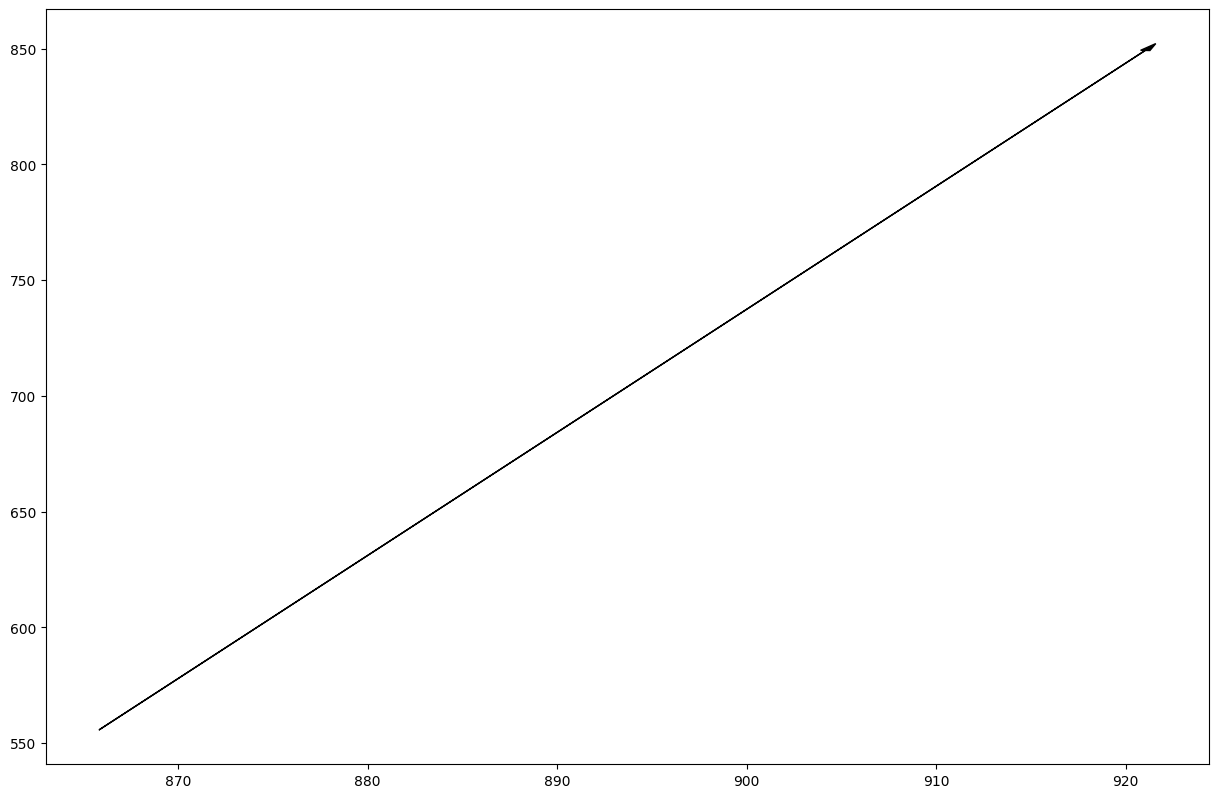

In [26]:
display(df.reset_index().head())
display(df.x.iloc[0],  df.y.iloc[0], df.x.iloc[1], df.y.iloc[1])
fig = plt.figure(figsize=(15, 10), dpi=100)
plt.arrow(x = df.x.iloc[0], y = df.y.iloc[0], dx = (df.x.iloc[1] - df.x.iloc[0]), dy = (df.y.iloc[1] - df.y.iloc[0]), head_width=0.5, head_length=3, fc='k', ec='k')


D:\Users\PC\anaconda3\envs\spyder-4.2.5\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PC\AppData\Local\Temp/ipykernel_10068/2689436423.py:31: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = mpl.colorbar.ColorbarBase(display_axes, cmap=cmap,


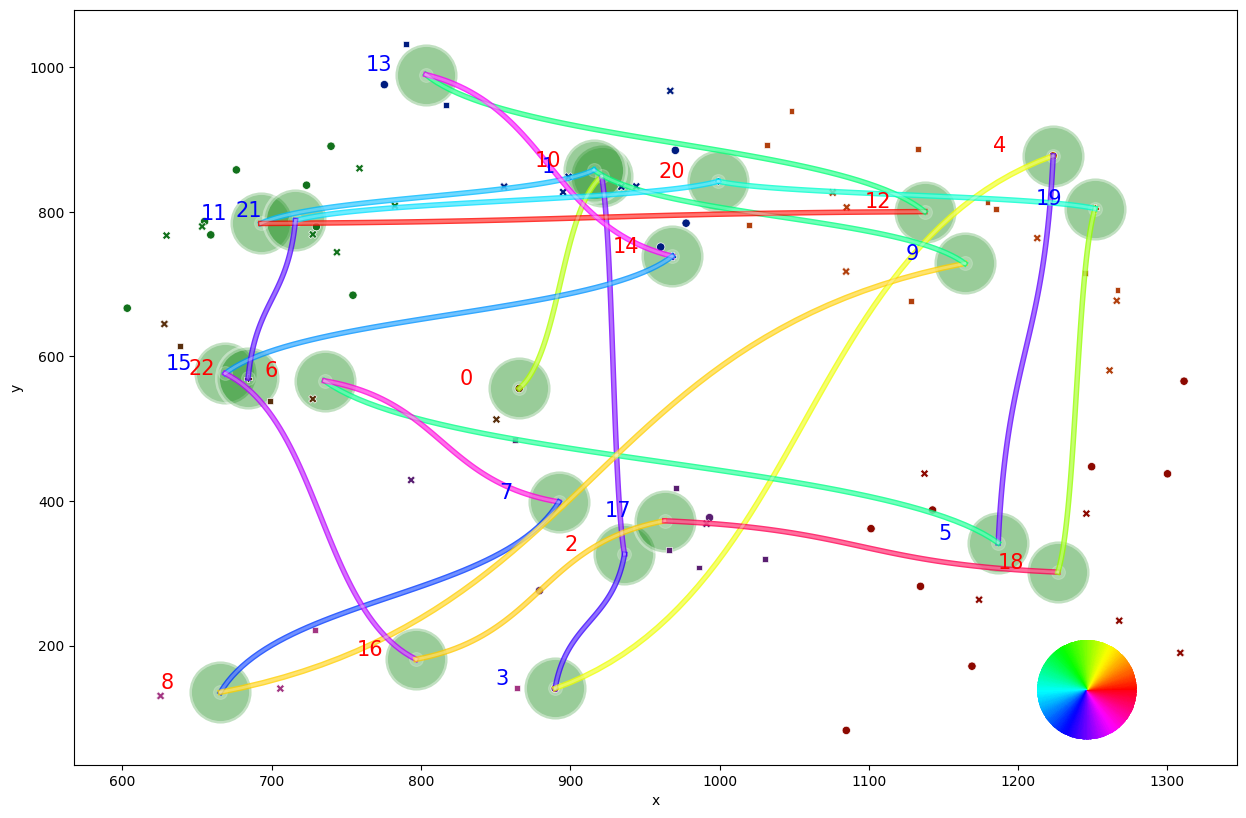

In [27]:
from matplotlib.pyplot import figure
import matplotlib as mpl

img_path = r'C:\Users\PC\Desktop\SEMESTER 5\Krejz\to_R\casa2.jpeg'
img = plt.imread(img_path)

fig = plt.figure(figsize=(15, 10), dpi=100)

for i in range(len(nazwa_1.edges)):
    plt.plot(nazwa_1.edges['x'][i], nazwa_1.edges['y'][i], color = nazwa_1.edges['color'][i], alpha = 0.8, linewidth = 4)
for i in range(len(nazwa_1.edges)):
    plt.plot(nazwa_1.edges['x'][i], nazwa_1.edges['y'][i], color = 'w', alpha = 0.3, linewidth = 2)
"""   
for i in range(len(df)-1):
    plt.arrow(x = df.x.iloc[i], y = df.y.iloc[i], dx = (df.x.iloc[i+1] - df.x.iloc[i]), dy = (df.y.iloc[i+1] - df.y.iloc[i]), head_width=0.5, head_length=3, fc='k', ec='k')
"""
    
sns.scatterplot(x = df.x, y = df.y, s = 2000, alpha = 0.4, color = 'g')
sns.scatterplot(x = df.x, y = df.y, s = 100, alpha = 0.2, color = 'w')
sns.scatterplot(df_with_time_claster.mean_x_k, df_with_time_claster.mean_y_k, hue = df_with_time_claster.klaster, 
                palette = 'dark', style = df_with_time_claster.time_klaster, legend = False)

for line in range(0, df_to_R.shape[0]):
    plt.text(x = df_to_R.x[line]-40, y = df_to_R.y[line]+5, s = df_to_R.index[line], 
             fontdict = dict(color = 'red' if line % 2 == 0 else 'blue', size = 15))
ax.imshow(img)

display_axes = fig.add_axes([0.75,0.15,0.1,0.1], projection='polar')
display_axes._direction = 2*np.pi
norm = mpl.colors.Normalize(0.0, 2*np.pi)
cb = mpl.colorbar.ColorbarBase(display_axes, cmap=cmap,
                                   norm=norm,
                                   orientation='horizontal')
cb.outline.set_visible(False)                                 
display_axes.set_axis_off()

plt.show()

Próby dopasowania zdjecia:

D:\Users\PC\anaconda3\envs\spyder-4.2.5\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\PC\AppData\Local\Temp/ipykernel_10068/694617994.py:27: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb = mpl.colorbar.ColorbarBase(display_axes, cmap=cmap,


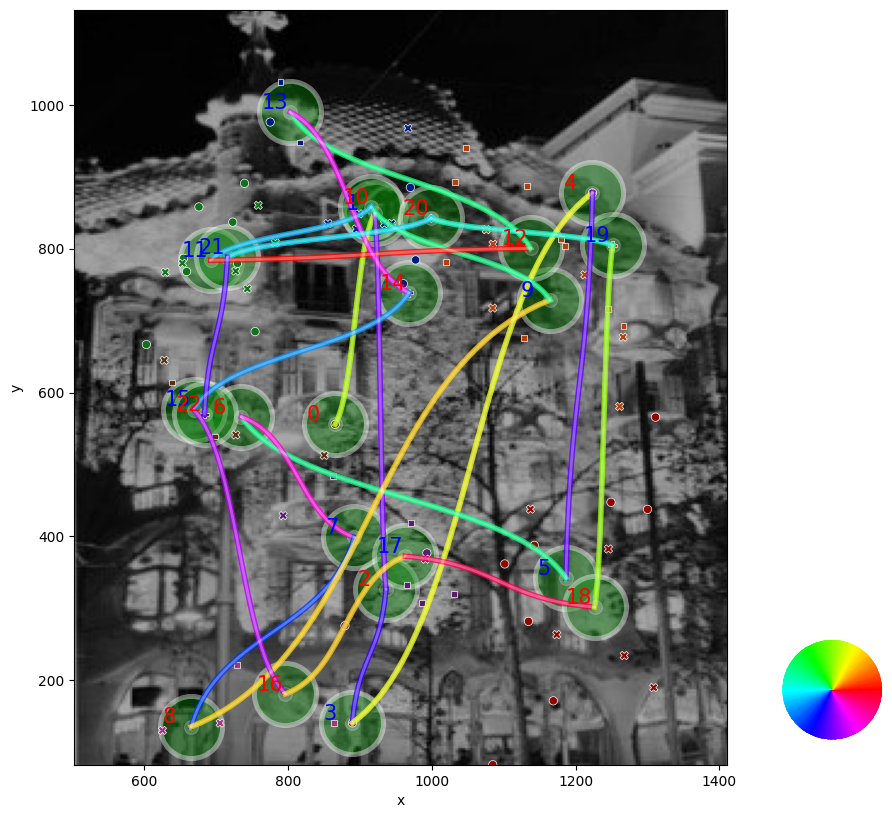

In [28]:
from matplotlib.pyplot import figure
import matplotlib as mpl

img_path = r'C:\Users\PC\Desktop\SEMESTER 5\Krejz\to_R\casa3.jpeg'
img = plt.imread(img_path)

fig, ax = plt.subplots(figsize=(15, 10), dpi=100)

for i in range(len(nazwa_1.edges)):
    ax.plot(nazwa_1.edges['x'][i], nazwa_1.edges['y'][i], color = nazwa_1.edges['color'][i], alpha = 0.8, linewidth = 4)
for i in range(len(nazwa_1.edges)):
    ax.plot(nazwa_1.edges['x'][i], nazwa_1.edges['y'][i], color = 'w', alpha = 0.3, linewidth = 2)
    
sns.scatterplot(x = df.x, y = df.y, s = 2000, alpha = 0.4, color = 'g', ax = ax)
sns.scatterplot(x = df.x, y = df.y, s = 100, alpha = 0.2, color = 'w', ax = ax)
sns.scatterplot(df_with_time_claster.mean_x_k, df_with_time_claster.mean_y_k, hue = df_with_time_claster.klaster, 
                palette = 'dark', style = df_with_time_claster.time_klaster, legend = False, ax= ax)

for line in range(0, df_to_R.shape[0]):
    ax.text(x = df_to_R.x[line]-40, y = df_to_R.y[line]+5, s = df_to_R.index[line], 
             fontdict = dict(color = 'red' if line % 2 == 0 else 'blue', size = 15))


display_axes = fig.add_axes([0.75,0.15,0.1,0.1], projection='polar')
display_axes._direction = 2*np.pi
norm = mpl.colors.Normalize(0.0, 2*np.pi)
cb = mpl.colorbar.ColorbarBase(display_axes, cmap=cmap,
                                   norm=norm,
                                   orientation='horizontal')
cb.outline.set_visible(False)                                 
display_axes.set_axis_off()
ax.imshow(img, extent=[df_D_casa['mean_x'].min() - 100, df_D_casa['mean_x'].max() + 100, 
                                  df_D_casa['mean_y'].min(), df_D_casa['mean_y'].max() + 100])
plt.show()

